In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rdkit
from rdkit import Chem

In [2]:
##Importing the training dataset
train_df = pd.read_csv('../data/train.csv')

In [3]:
##Cleaning out the zero columns
cols = train_df.columns
nonzero_cols = cols[(train_df != 0).any(axis=0)]
train_df = train_df[nonzero_cols]
ncols = len(train_df.columns)

In [29]:
##Converting all smiles to strings
train_df['smiles_str'] = train_df['smiles'].astype(str)

In [41]:
##Testing RDKIT features
train_df['smiles_mol'] = train_df['smiles'].apply(lambda x: Chem.MolFromSmiles(str(x)))

In [53]:
##selecting columns without smiles_mol and smiles_str
cols = train_df.columns
select_cols = cols.difference(['smiles_mol', 'smiles_str'])
train = train_df[select_cols]

In [62]:
##Applying the descriptors and appending to the train_df
train = pd.concat([train,\
           train_df.smiles_mol.apply(lambda s: pd.Series(generate_rdk_features(s)))], axis=1)

In [61]:
pd.concat([train.head(),\
    train_df.head().smiles_mol.apply(lambda s: pd.Series(generate_rdk_features(s)))], axis=1)

,feat_001,feat_005,feat_006,feat_007,feat_025,feat_037,feat_044,feat_068,feat_069,feat_072,...,MolLogP,NOCount,NumHAcceptors,NumHDonors,NumHeteroAtoms,NumRadicalElectrons,NumSaturatedRings,NumValenceElectrons,RingCount,TPSA
0,0,1,0,1,0,0,0,1,0,1,...,6.0135,4,7,0,8,0,0,130,6,51.81
1,1,1,0,1,1,1,0,0,1,1,...,0.5631,2,2,0,4,0,0,118,6,25.78
2,1,1,1,1,0,1,0,1,1,1,...,3.5704,3,4,1,6,0,0,128,7,41.57
3,1,1,1,1,1,0,0,1,0,0,...,0.3159,2,1,1,4,0,0,128,7,28.93
4,0,1,0,1,0,0,0,0,0,1,...,4.7371,8,9,0,9,0,0,136,7,103.62


In [60]:
from rdkit.Chem import Descriptors
def generate_rdk_features(rdk):
    return_dict ={}
    return_dict['TPSA'] = Descriptors.TPSA(rdk)
    return_dict['MolLogP'] = Descriptors.MolLogP(rdk)
    return_dict['RingCount'] = Descriptors.RingCount(rdk)
    return_dict['NumHAcceptors'] = Descriptors.NumHAcceptors(rdk)
    return_dict['NumHDonors'] = Descriptors.NumHDonors(rdk)
    return_dict['NumHeteroAtoms'] = Descriptors.NumHeteroatoms(rdk)
    return_dict['NumValenceElectrons'] = Descriptors.NumValenceElectrons(rdk)
    return_dict['NumRadicalElectrons'] = Descriptors.NumRadicalElectrons(rdk)
    return_dict['NOCount'] = Descriptors.NOCount(rdk)
    return_dict['NumSaturatedRings'] = Descriptors.NumSaturatedRings(rdk)
    return return_dict

In [63]:
train.to_csv('../data/train_new_features.csv')

In [64]:
train.columns

Index([u'feat_001', u'feat_005', u'feat_006', u'feat_007', u'feat_025',
       u'feat_037', u'feat_044', u'feat_068', u'feat_069', u'feat_072',
       u'feat_087', u'feat_090', u'feat_102', u'feat_119', u'feat_123',
       u'feat_126', u'feat_132', u'feat_173', u'feat_176', u'feat_187',
       u'feat_196', u'feat_199', u'feat_200', u'feat_208', u'feat_218',
       u'feat_225', u'feat_226', u'feat_243', u'feat_248', u'feat_251',
       u'feat_252', u'gap', u'smiles', u'MolLogP', u'NOCount',
       u'NumHAcceptors', u'NumHDonors', u'NumHeteroAtoms',
       u'NumRadicalElectrons', u'NumSaturatedRings', u'NumValenceElectrons',
       u'RingCount', u'TPSA'],
      dtype='object')

#### Random Forest Regressor

In [65]:
##Setting up random forests for feature importance calculations
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split

In [66]:
##Splitting the training set into test and training set
train_cols = train.columns
train_cols = train_cols.difference(['smiles', 'gap'])
X = train[train_cols]
y = train['gap']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=1)
print X_train.shape, X_test.shape

(900000, 41) (100000, 41)


In [105]:
##Training the random forest regressor
RF = RandomForestRegressor(n_estimators=50)
RF.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [106]:
from harness import RMSE
predicted = RF.predict(X_test)
RMSE(predicted, y_test)

RMSE =  0.159635039534


0.1596350395343179

In [73]:
##Prepping test set with the new features
test_df = pd.read_csv('../data/test.csv')
test_df['smiles_mol'] = test_df['smiles'].apply(lambda x: Chem.MolFromSmiles(str(x)))

In [74]:
test_df = pd.concat([test_df,\
           test_df.smiles_mol.apply(lambda s: pd.Series(generate_rdk_features(s)))], axis=1)

In [78]:
test_cols = test_df.columns
test_cols = test_cols.difference(['smiles','smiles_mol'])

#### Save test data

In [112]:
test_sv_cols = test_df.columns
test_sv_cols = test_sv_cols.difference(['smiles_mol'])
cols = test_df.columns
nonzero_sv_cols = cols[(test_df != 0).any(axis=0)]
test_pr_sv = test_df[nonzero_sv_cols]

In [122]:
test_pr_sv['NumRadicalElectrons'] = test_df['NumRadicalElectrons']
test_pr_sv['NumSaturatedRings'] = test_df['NumSaturatedRings']
test_pr_sv.drop('Id', axis=1, inplace=True)

/Users/abhishek/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/abhishek/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/abhishek/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org

In [124]:
test_pr_sv.to_csv('../data/test_new_features.csv')

In [125]:
test_pr_sv.head()

,smiles,feat_001,feat_005,feat_006,feat_007,feat_025,feat_037,feat_044,feat_068,feat_069,...,MolLogP,NOCount,NumHAcceptors,NumHDonors,NumHeteroAtoms,NumValenceElectrons,RingCount,TPSA,NumRadicalElectrons,NumSaturatedRings
0,c1sc(-c2cnc3c(c2)c2nsnc2c2cc4cccnc4cc32)c2cc[n...,0,1,1,1,0,0,0,1,0,...,6.1507,5,6,1,7,136,7,67.35,0,0
1,[nH]1cccc1-c1cc2c3nsnc3c3c4sccc4[nH]c3c2s1,0,1,1,1,0,0,0,1,0,...,5.5971,4,5,2,7,110,6,57.36,0,0
2,[nH]1c2cc(-c3ccc[se]3)c3nsnc3c2c2c3cscc3c3ccc4...,1,1,1,1,1,0,0,0,0,...,4.0761,3,4,1,7,146,8,41.57,0,0
3,[nH]1c(cc2cnc3c(c12)c1=C[SiH2]C=c1c1ccc2=CCC=c...,1,1,1,1,1,0,0,1,0,...,1.7524,3,2,1,4,132,7,41.82,0,0
4,c1sc(-c2sc(-c3sc(-c4scc5[se]ccc45)c4ccoc34)c3c...,0,1,0,1,0,0,0,1,0,...,9.8509,2,7,0,8,154,8,26.28,0,0


In [121]:
nonzero_sv_cols.difference(train.columns)

Index([u'Id', u'smiles_mol'], dtype='object')

In [79]:
test = test_df[test_cols]

In [95]:
##Cleaning out the zero columns
cols = test.columns
nonzero_cols = cols[(test != 0).any(axis=0)]
test_pr = test[nonzero_cols]

In [98]:
test_pr['NumRadicalElectrons'] = test['NumRadicalElectrons']
test_pr['NumSaturatedRings'] = test['NumSaturatedRings']
test_pr.drop('Id', axis=1, inplace=True)

/Users/abhishek/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/abhishek/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/abhishek/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org

In [100]:
test_pr.head()

,MolLogP,NOCount,NumHAcceptors,NumHDonors,NumHeteroAtoms,NumValenceElectrons,RingCount,TPSA,feat_001,feat_005,...,feat_208,feat_218,feat_225,feat_226,feat_243,feat_248,feat_251,feat_252,NumRadicalElectrons,NumSaturatedRings
0,6.1507,5,6,1,7,136,7,67.35,0,1,...,0,0,1,1,1,1,0,0,0,0
1,5.5971,4,5,2,7,110,6,57.36,0,1,...,0,0,1,1,1,1,0,0,0,0
2,4.0761,3,4,1,7,146,8,41.57,1,1,...,0,1,0,1,1,1,0,0,0,0
3,1.7524,3,2,1,4,132,7,41.82,1,1,...,0,1,0,1,1,1,0,0,0,0
4,9.8509,2,7,0,8,154,8,26.28,0,1,...,0,0,0,1,0,1,0,0,0,0


In [83]:
train.head()

,feat_001,feat_005,feat_006,feat_007,feat_025,feat_037,feat_044,feat_068,feat_069,feat_072,...,MolLogP,NOCount,NumHAcceptors,NumHDonors,NumHeteroAtoms,NumRadicalElectrons,NumSaturatedRings,NumValenceElectrons,RingCount,TPSA
0,0,1,0,1,0,0,0,1,0,1,...,6.0135,4,7,0,8,0,0,130,6,51.81
1,1,1,0,1,1,1,0,0,1,1,...,0.5631,2,2,0,4,0,0,118,6,25.78
2,1,1,1,1,0,1,0,1,1,1,...,3.5704,3,4,1,6,0,0,128,7,41.57
3,1,1,1,1,1,0,0,1,0,0,...,0.3159,2,1,1,4,0,0,128,7,28.93
4,0,1,0,1,0,0,0,0,0,1,...,4.7371,8,9,0,9,0,0,136,7,103.62


In [102]:
test_predictions = RF.predict(test_pr)

In [103]:
out_df = pd.DataFrame({'Id':range(1,len(test_predictions)+1), 'Prediction': test_predictions})
out_df = out_df.set_index('Id')
out_df.Prediction = out_df.Prediction.astype(float)

In [104]:
out_df.to_csv('../output/RF_new_features_abhi.csv')

In [126]:
##Implementing Lasso Regression
from sklearn.linear_model import Lasso
from sklearn.grid_search import GridSearchCV

In [127]:
lasso = GridSearchCV(Lasso(), {'alpha': np.logspace(-7, 0, 10)})
lasso.fit(X_train, y_train)

/Users/abhishek/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


GridSearchCV(cv=None, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': array([  1.00000e-07,   5.99484e-07,   3.59381e-06,   2.15443e-05,
         1.29155e-04,   7.74264e-04,   4.64159e-03,   2.78256e-02,
         1.66810e-01,   1.00000e+00])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [129]:
lasso_run = lasso.best_estimator_

In [160]:
lasso_run = Lasso(alpha=1e-8, normalize=True)

In [161]:
lasso_run.fit(X_train, y_train)

Lasso(alpha=1e-08, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [162]:
predicted_lasso = lasso_run.predict(X_test)
RMSE(predicted_lasso, y_test)

RMSE =  0.232473118212


0.23247311821163075

In [163]:
test_predictions = lasso_run.predict(test_pr)
out_df = pd.DataFrame({'Id':np.array(test_df.Id), 'Prediction': test_predictions})
out_df = out_df.set_index('Id')
out_df.Prediction = out_df.Prediction.astype(float)

(array([  5.20000000e+01,   1.75400000e+03,   1.98590000e+04,
          7.45370000e+04,   1.56101000e+05,   2.22972000e+05,
          2.11901000e+05,   1.14584000e+05,   2.21420000e+04,
          3.28000000e+02]),
 array([ 1.02969167,  1.31486082,  1.60002997,  1.88519912,  2.17036827,
         2.45553742,  2.74070657,  3.02587572,  3.31104487,  3.59621402,
         3.88138317]),
 <a list of 10 Patch objects>)

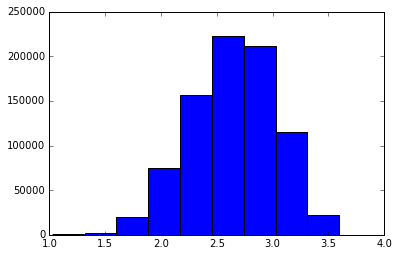

In [164]:
%matplotlib inline
plt.hist(out_df.Prediction)

(array([ 575412.,  418246.,    3333.]),
 array([1, 2, 3, 4]),
 <a list of 3 Patch objects>)

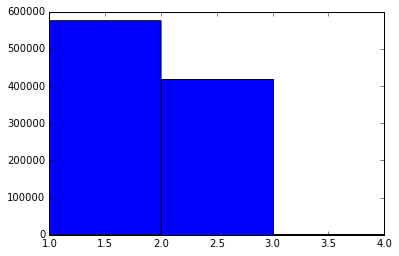

In [165]:
plt.hist(train_df.gap,bins=range(1,5))

In [166]:
out_df

,Prediction
Id,
1,2.181191
2,1.956786
3,1.851210
4,2.316023
5,2.101556
6,2.991449
7,2.661796
8,2.831410
9,2.293709


In [171]:
from pybrain.structure import FeedForwardNetwork
from pybrain.structure import LinearLayer, SigmoidLayer
from pybrain.structure import FullConnection
from pybrain.supervised.trainers import BackpropTrainer
from pybrain.datasets import SupervisedDataSet

In [172]:
hidden_layer_size = 500
n = FeedForwardNetwork()
inLayer = LinearLayer(X_train.shape[1])
hiddenLayer = SigmoidLayer(hidden_layer_size)
outLayer = LinearLayer(1)

In [173]:
n.addInputModule(inLayer)
n.addModule(hiddenLayer)
n.addOutputModule(outLayer)
in_to_hidden = FullConnection(inLayer, hiddenLayer)
hidden_to_out = FullConnection(hiddenLayer, outLayer)
n.addConnection(in_to_hidden)
n.addConnection(hidden_to_out)
n.sortModules()
print n

FeedForwardNetwork-6
   Modules:
    [<LinearLayer 'LinearLayer-3'>, <SigmoidLayer 'SigmoidLayer-7'>, <LinearLayer 'LinearLayer-8'>]
   Connections:
    [<FullConnection 'FullConnection-4': 'LinearLayer-3' -> 'SigmoidLayer-7'>, <FullConnection 'FullConnection-5': 'SigmoidLayer-7' -> 'LinearLayer-8'>]



In [174]:
ds = SupervisedDataSet(X_train.shape[1],1)
tr_cols = X_train.columns
for index, row in X_train.iterrows():
    ds.addSample(tuple(row), y_train.loc[index])

In [179]:
X_test.columns

Index([u'MolLogP', u'NOCount', u'NumHAcceptors', u'NumHDonors',
       u'NumHeteroAtoms', u'NumRadicalElectrons', u'NumSaturatedRings',
       u'NumValenceElectrons', u'RingCount', u'TPSA', u'feat_001', u'feat_005',
       u'feat_006', u'feat_007', u'feat_025', u'feat_037', u'feat_044',
       u'feat_068', u'feat_069', u'feat_072', u'feat_087', u'feat_090',
       u'feat_102', u'feat_119', u'feat_123', u'feat_126', u'feat_132',
       u'feat_173', u'feat_176', u'feat_187', u'feat_196', u'feat_199',
       u'feat_200', u'feat_208', u'feat_218', u'feat_225', u'feat_226',
       u'feat_243', u'feat_248', u'feat_251', u'feat_252'],
      dtype='object')

In [175]:
trainer = BackpropTrainer(n, ds)
trainer.train()

22690246362.236774

In [176]:
squared_error = 0.0
for index, row in X_test.iterrows():
    y_pred = n.activate(tuple(row))
    y_actual = y_test.loc[index]
    squared_error += (y_pred - y_actual)**2
RMSE_val = np.sqrt(squared_error/len(X_test))

In [177]:
RMSE_val

array([ 3.25214746])